In [213]:
import os
import sys
import pickle
import random
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order


sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline


def test_4_stationary(X):
    result = adfuller(X)
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in result[4].items():
        print(' - %s: %.3f' % (key, value))
    print(f"Is the time series stationary? {pvalue < 0.05}")
    return pvalue < 0.05

def test_4_cointegration(y1, y2):
    result = coint(y1, y2)
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in zip([1, 5, 10], result[2]):
        print(f' - {key}%: {round(value, 3)}')
    print(f"Is time series cointegrate? {pvalue < 0.05}")
    return pvalue < 0.05

def autoregression_model(y1, y2, columns):
    print("Augmented Dickey-Fuller Test:")
    print("-" * 30)
    print()

    print(f"{columns[0]}:")
    print("-" * 30)
    y1_is_stationary = test_4_stationary(y1)

    print()
    print(f"{columns[1]}:")
    print("-" * 30)
    y2_is_stationary = test_4_stationary(y2)

    print()
    print()
    print("Engle-Granger Test:")
    print("-" * 30)
    print()
    is_cointegrate = test_4_cointegration(y1, y2)
    print()
    
    
    result = None
    df_int_ = pd.DataFrame(np.c_[y1, y2], columns=columns)
    # VECM
    if (not y1_is_stationary and not y2_is_stationary) and is_cointegrate:
        print("Vector Error Correction Models (VECM):")
        print("-" * 30)
        result = VECM(df_int_).fit()
        print(result.test_granger_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    # VAR
    elif (y1_is_stationary and y2_is_stationary):
        print("Vector Autoregressions (VAR):")
        print("-" * 30)
        model = VAR(df_int_)
        result = model.fit(ic="aic")
        print(result.test_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    else:
        print("!!! Can find a model that could fit the series, please make the series stationary !!!")
    if result:
        result.plot_forecast(steps=3)
    return result
    

def gerar_graficos(x1, x2, datas, columns, steps=5, stationary=False):
    x1_scale = scale(x1)
    x2_scale = scale(x2)
    cumsum_x1 = scale(np.cumsum(x1))
    cumsum_x2 = scale(np.cumsum(x2))
    if stationary:
        cumsum_x1 = scale(np.cumsum(np.cumsum(x1)))
        cumsum_x2 = scale(np.cumsum(np.cumsum(x2)))
        

    tempo = np.arange(1, len(datas) + 1)
    numero_tempo = list(np.arange(1, len(datas), steps))
    numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
    data_tempo = list(datas[::steps]) + [datas[-1]]
    
    try:
        idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
        idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
        idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
    except:
        pass
    idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
    idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
    mmin, mmax = np.min(novos_casos), np.max(novos_casos)

    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.title(f"Comparativo : {columns[0]} x {columns[1]} : Brasil")
    plt.plot(tempo, x1_scale, label=columns[0])
    plt.plot(tempo, x2_scale, label=columns[1])
    try:
        plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
        plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
        plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
    except:
        pass
    plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
    plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
    plt.xticks(numero_tempo, data_tempo, rotation=75)
    plt.xlabel("Data")
    plt.ylabel("Normalizado")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title(f"Comparativo : {columns[0]} x {columns[1]} : Soma Acumulada : Brasil")
    plt.plot(tempo, cumsum_x1, label=columns[0])
    plt.plot(tempo, cumsum_x2, label=columns[1])
    try:
        plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
        plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
        plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
    except:
        pass
    plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
    plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
    plt.xticks(numero_tempo, data_tempo, rotation=75)
    plt.xlabel("Data")
    plt.ylabel("Normalizado")
    plt.legend()
    plt.tight_layout()
    plt.show()
    return x1_scale, x2_scale
    
normalizar = CleanUp(remove_stopwords=True)

In [145]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-16.csv")
# print(df_covid.columns)

In [146]:
covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()

In [3]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]
users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [4]:
# print(hashtags_.columns)
# print(users_.columns)

## Informações da base de dados

In [147]:
print(f"Qtde. de Comentários            : {len(hashtags_)}")
print(f"Qtde. de Comentários positivos  : {len(hashtags_[hashtags_['classify'] == 'positivo'])}")
print(f"Qtde. de Comentários negativos  : {len(hashtags_[hashtags_['classify'] == 'negativo'])}")
print("-" * 40)
print(f"Qtde. de Usuários geolocalizados: {len(users_)}")
print(f"Qtde. de Usuários em SP         : {len(users_[users_['state'] == 'SP'])}")
print(f"Qtde. de Usuários em RJ         : {len(users_[users_['state'] == 'RJ'])}")

Qtde. de Comentários            : 283392
Qtde. de Comentários positivos  : 109490
Qtde. de Comentários negativos  : 139147
----------------------------------------
Qtde. de Usuários geolocalizados: 64899
Qtde. de Usuários em SP         : 12763
Qtde. de Usuários em RJ         : 13513


Exemplos de comentários com suas classificações:

In [148]:
for idx, row in hashtags_.sample(n=5).iterrows():
    print(f"{row.classify}|{row.comment}")

negativo|Minha mãe vai começar a fazer aula de zumba amanhã, se eu não peguei corona até agora, agora eu pego
positivo|Uma falta de ar
positivo|EU NUNCA TINHA VISTO ESSE VÍDEO INTEIRO. EU TO COM FALTA DE AR
negativo|Em resposta a  @carolinaprivv1 vamos as duas mana , febre não está a passar :(
positivo|Rafa com febre parte meu coração


## Nuvens de palavras

Nuvem de palavras de todos os comentários na base de dados.

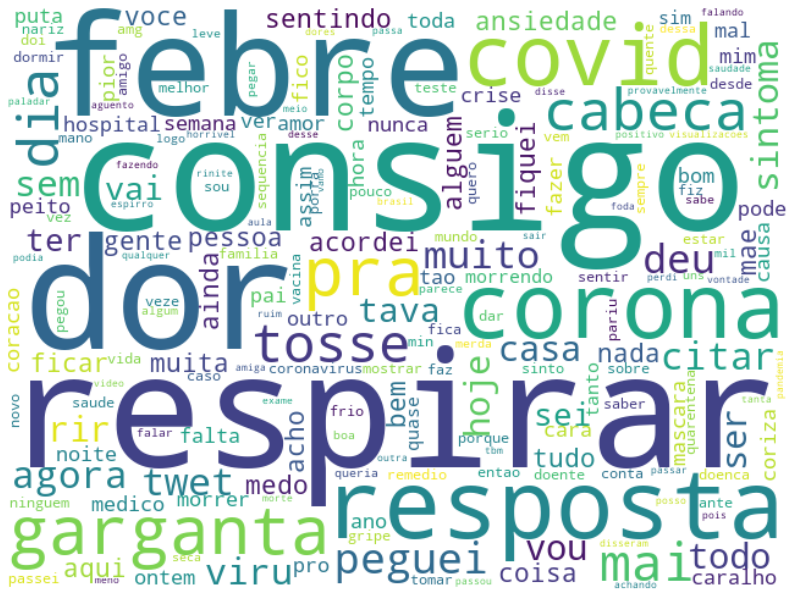

In [299]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nuvens de palavras apenas de comentários classificados como positivos.

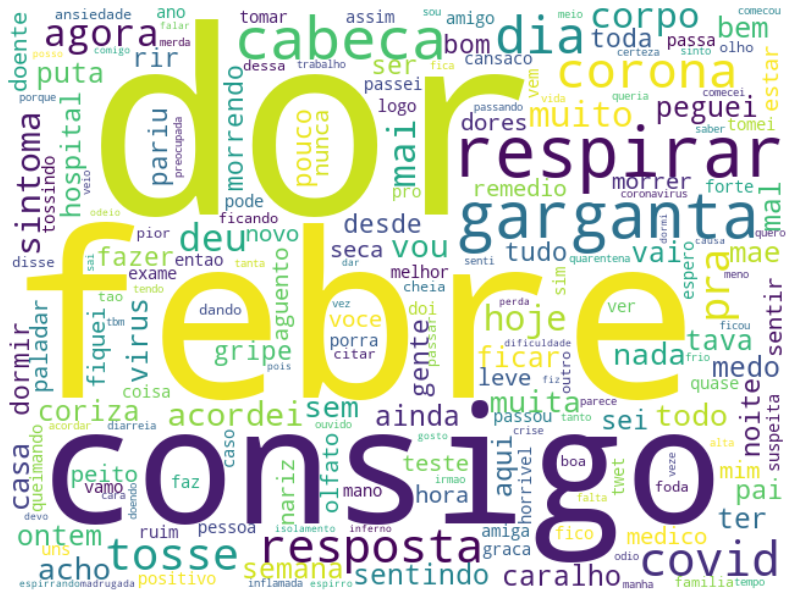

In [300]:
wordcloud = WordCloud(
    width=640, height=480,
    background_color="white", collocations=False,
    stopwords=["nao", "estou", "duvida"]
).generate(" ".join([normalizar.fit(frase) for frase in hashtags_[hashtags_['classify'] == 'positivo']["clean_comment"].tolist()]))

plt.figure(figsize=(14, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Visualizações dos dados

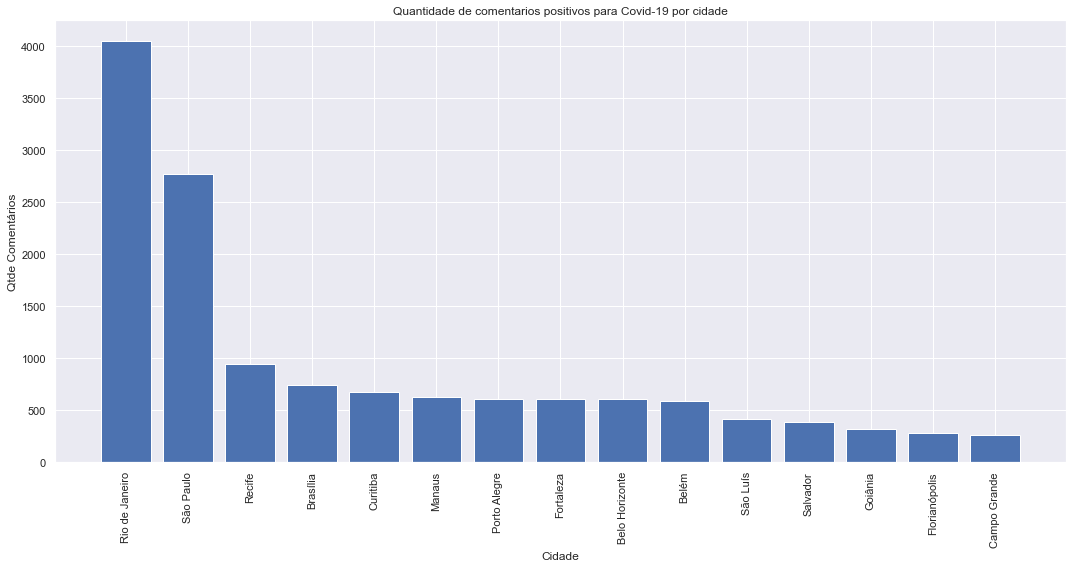

In [7]:
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['city']).sum().reset_index()[['city', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por cidade")
plt.bar(usr['city'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Cidade")
plt.ylabel("Qtde Comentários")
plt.tight_layout()
plt.show()

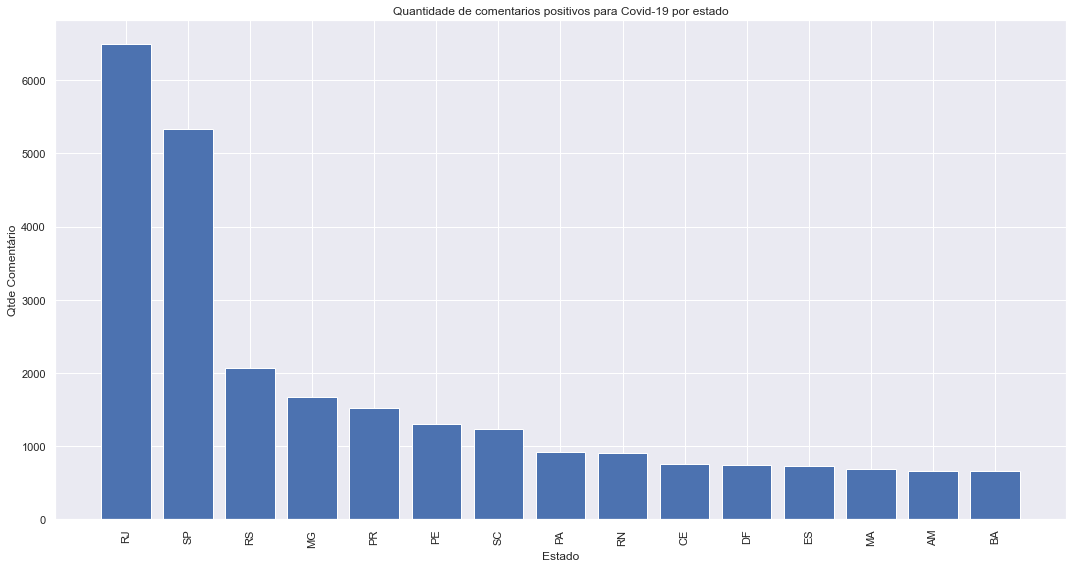

In [8]:
# Pega todos os usuarios do estado de sao paulo
# sp = users_[users_['state'] == 'SP'].copy()
# Sem filtrar por estado...
usr = users_.copy()
usr['count'] = 1
# filtra estes usuarios com comentarios identificados como positivo
nusr = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')]['username']
# Tendo os usuarios com comentarios positivos filtra novamente
usr = usr[usr['username'].isin(nusr)]
# Agrupa e soma a quantidade por cidade do estado de sao paulo
usr = usr.drop_duplicates("username").groupby(['state']).sum().reset_index()[['state', 'count']].sort_values(by=['count'], ascending=False)

# Grafico
plt.figure(figsize=(15, 8))
plt.title("Quantidade de comentarios positivos para Covid-19 por estado")
plt.bar(usr['state'][:15], usr['count'][:15])
plt.xticks(rotation=90)
plt.xlabel("Estado")
plt.ylabel("Qtde Comentário")
plt.tight_layout()
plt.show()

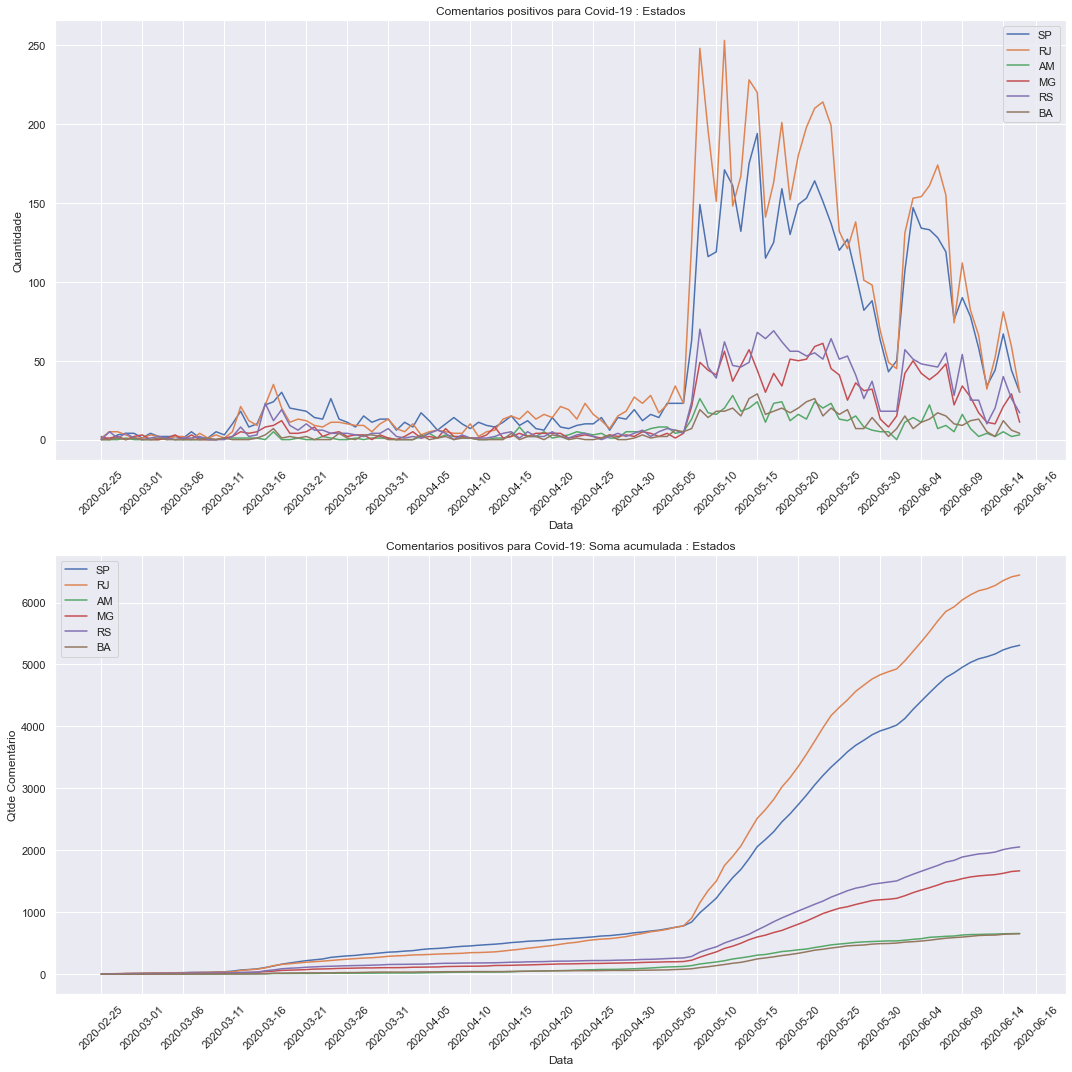

In [9]:
usr = users_.copy()

estados = ["SP", "RJ", "AM", "MG", "RS", "BA"]
list_df = []
for estado in estados:
    usr_ = usr[usr["state"] == estado]
    df_dt_ = hashtags_[
        (hashtags_['username'].isin(usr_['username'])) & (hashtags_['classify'] == 'positivo')
    ].drop_duplicates("username").copy()
    df_dt_['date'] = df_dt_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
    df_dt_['count'] = 1
    df_dt_ = df_dt_.groupby([df_dt_['date'].dt.date]).sum().reset_index()
    df_dt_ = df_dt_[df_dt_['date'] > pd.Timestamp(2020, 1, 1)]
    list_df.append(df_dt_)

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search, list_cnt = row["date"], []
    for df_search in list_df:
        val_ = 0
        found_ = df_search[df_search["date"] == dt_search]
        if len(found_) > 0:
            val_ = int(found_["count"])
        list_cnt.append(val_)
    df_merged.append([dt_search] + list_cnt)
df_merged = pd.DataFrame(df_merged, columns=["date"] + estados)


datas = df_merged["date"].to_numpy()
tempo = np.arange(1, len(datas) + 1)
numero_tempo = list(np.arange(1, len(datas), steps))
numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
data_tempo = list(datas[::steps]) + [datas[-1]]

steps = 5
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.title("Comentarios positivos para Covid-19 : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    plt.plot(tempo, cnt_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Quantidade")
plt.legend()
plt.subplot(2, 1, 2)
plt.title("Comentarios positivos para Covid-19: Soma acumulada : Estados")
for estado in estados:
    cnt_ = df_merged[estado]
    cumsum_ = np.cumsum(cnt_)
    plt.plot(tempo, cumsum_, label=estado)
plt.xticks(numero_tempo, data_tempo, rotation=45)
plt.xlabel("Data")
plt.ylabel("Qtde Comentário")
plt.legend()
plt.tight_layout()
plt.show()

## Verificação de Causalidade

Lembrando as perguntas as quais deseja-se responder sobre essa análise:

 - É possível identificar a disseminação da COVID-19 no Brasil, através do conteúdo de redes sociais?
 - Sendo possível:
  - Com que grau de certeza a disseminação de COVID-19 é identificada?
  - Com que antecedência podemos identificar a disseminação da doença (em dias/semanas)?
  - Considerando que boa parte do conteúdo extraído não terá informações de geolocalização, é possível verificar essa disseminação por cidades ou estados?
  
Neste sentido, será necessário validar as séries temporais da quantidade de comentários ao longo de determinado período e a de Novo Casos / Mortes ao longo da pandemia.

Para esta análise, foi definido alguns limites:

 - Será feito uma análise do período todo de coleta.
  - Com relação a análise do período todo, é importante notar que a quantidade de comentários no Twitter da um grande salto a partir do dia 05/05, dessa maneira, será realizada uma análise deste período em diante para verificar se existe alguma modificação na relação causal.
 - Como visto acima, será selecionado apenas a análise dos estados de São Paulo e Rio de Janeiro por possuirem maior quantidade de comentários.

Estima-se que exite cerca de 8 milhões e 280 mil usuários no Twitter, entretanto no Brasil, tem-se aproximadamente 212 milhões de habitantes. Visto essa discrepância na quantidade de pessoas, para uma análise mais direcionada, os dados serão estandardizados:

$z = \frac{(x - \mu)}{\sigma}$

Após isso, para a análise de série temporais leva em consideração alguns aspectos.

A análise deve levar em consideração se as séries são estacionárias ou não. Sendo ambas estacionárias pode-se usar o modelo VAR (Vector Autoregression), que através deste pode-se validar a causalidade de Granger e instantânea entre as séries, além da possibilidade de predição (forecast).

Caso ambas as séries não sejam estacionárias, é válida a verificação se as mesmas são cointegradas, e se forem utiliza-se o modelo VECM (Vector Error Correction Models) permitindo a mesma validação que a apresentada pelo modelo VAR.

Se mesmo assim, não for possível aplicar nenhum do dois modelos, uma outra tentativa é transformar as séries (removendo um pequeno atraso (1 dia)) para que se tornem estacionárias. Feito isso o modelo VAR pode ser aplicado.

Para a verificar se as séries são estacionárias, é possível usar o teste de Dickey-Fuller, que verifica se as séries possuem raiz unitária.

No caso da verificação para validar se as séries são cointegradas, utiliza-se o teste de Engle-Granger.

### Período Completo

Como primeira análise, será aplicado o mencionado acima, na série temporal toda desde o "começo" da pandemia.

#### Novos Casos x Comentários Positivos

In [270]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

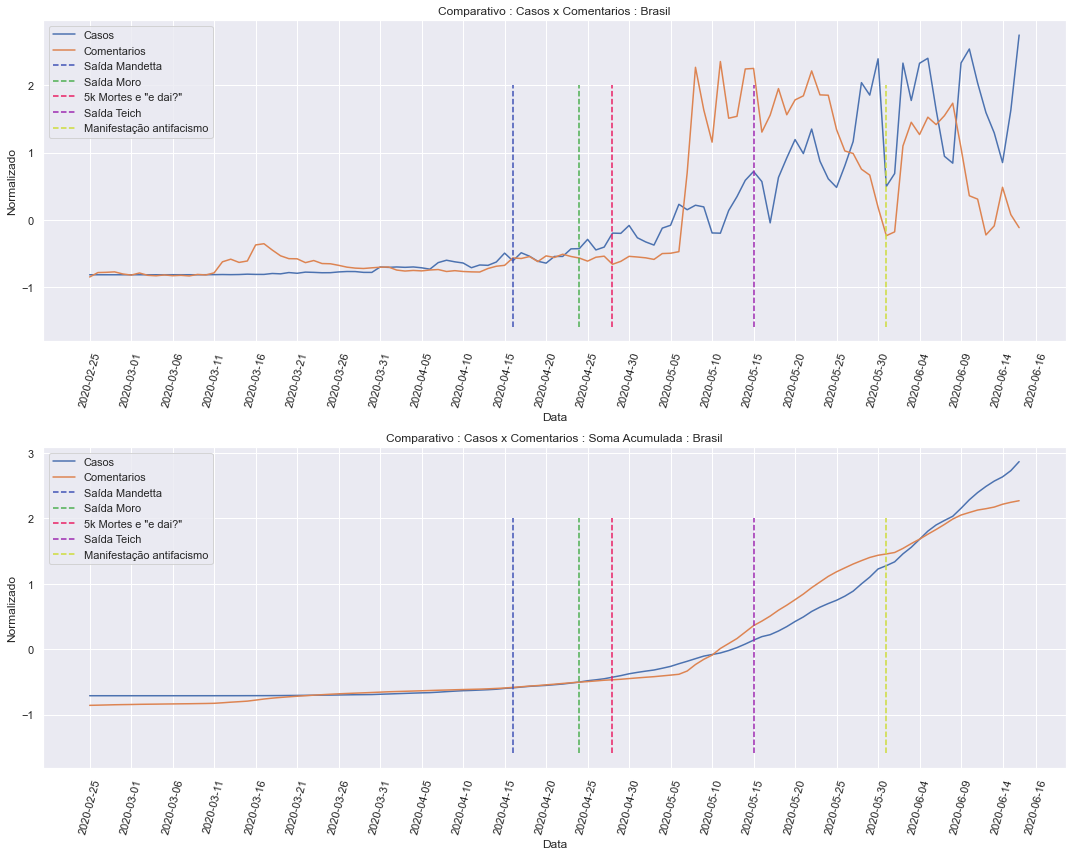

In [271]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [151]:
autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.430894
p-value: 0.567379
Critical Values:
 - 1%: -3.497
 - 5%: -2.891
 - 10%: -2.582
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 1.022437
p-value: 0.994497
Critical Values:
 - 1%: -3.495
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -1.678707
p-value: 0.686558
Critical Values:
 - 1%: -3.997
 - 5%: -3.391
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


Devido a ambas as séries não serem estacionárias, transforma-se ambas as séries removendo o atraso de 1 dia em ambas, tornando-as séries estacionárias.

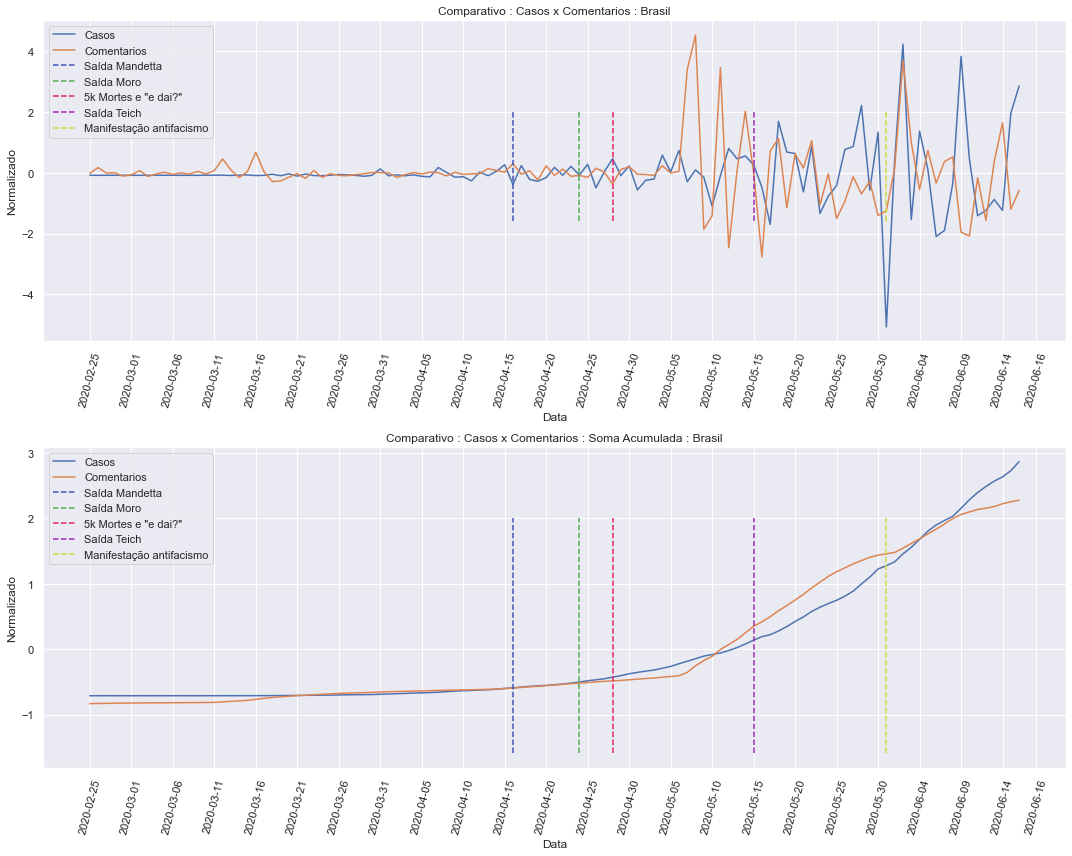

In [154]:
x1, x2 = gerar_graficos(df_merged["stationary_newCases"], df_merged["stationary_numComments"], datas, ["Casos", "Comentarios"], stationary=True)

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -3.043767
p-value: 0.031004
Critical Values:
 - 1%: -3.496
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? True

Casos:
------------------------------
ADF Statistic: -3.523951
p-value: 0.007393
Critical Values:
 - 1%: -3.494
 - 5%: -2.889
 - 10%: -2.582
Is the time series stationary? True


Engle-Granger Test:
------------------------------

ADF Statistic: -3.025488
p-value: 0.104271
Critical Values:
 - 1%: -3.997
 - 5%: -3.391
 - 10%: -3.083
Is time series cointegrate? False

Vector Autoregressions (VAR):
------------------------------
Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.338          1.816   0.203 (12, 152)
-----------------------------------------------




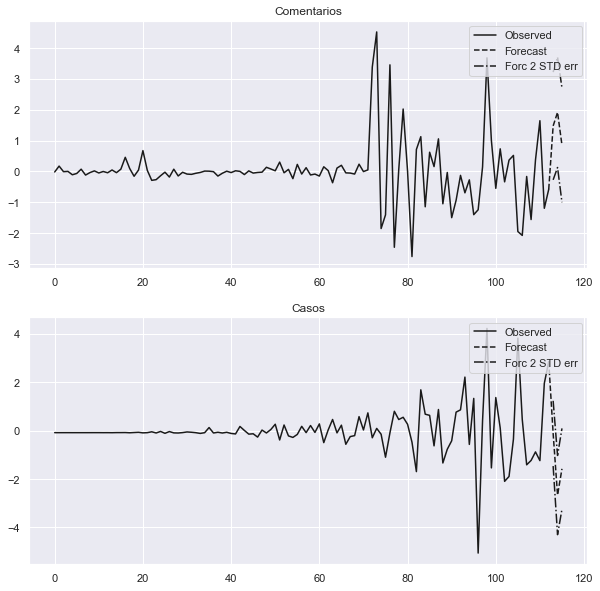

In [155]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

#### Mortes x Comentários Positivos

Dando sequência as validações, faz-se a verificação se os comentários no Twitter possuem uma relação causal na quantidade de mortes que ocorrem.

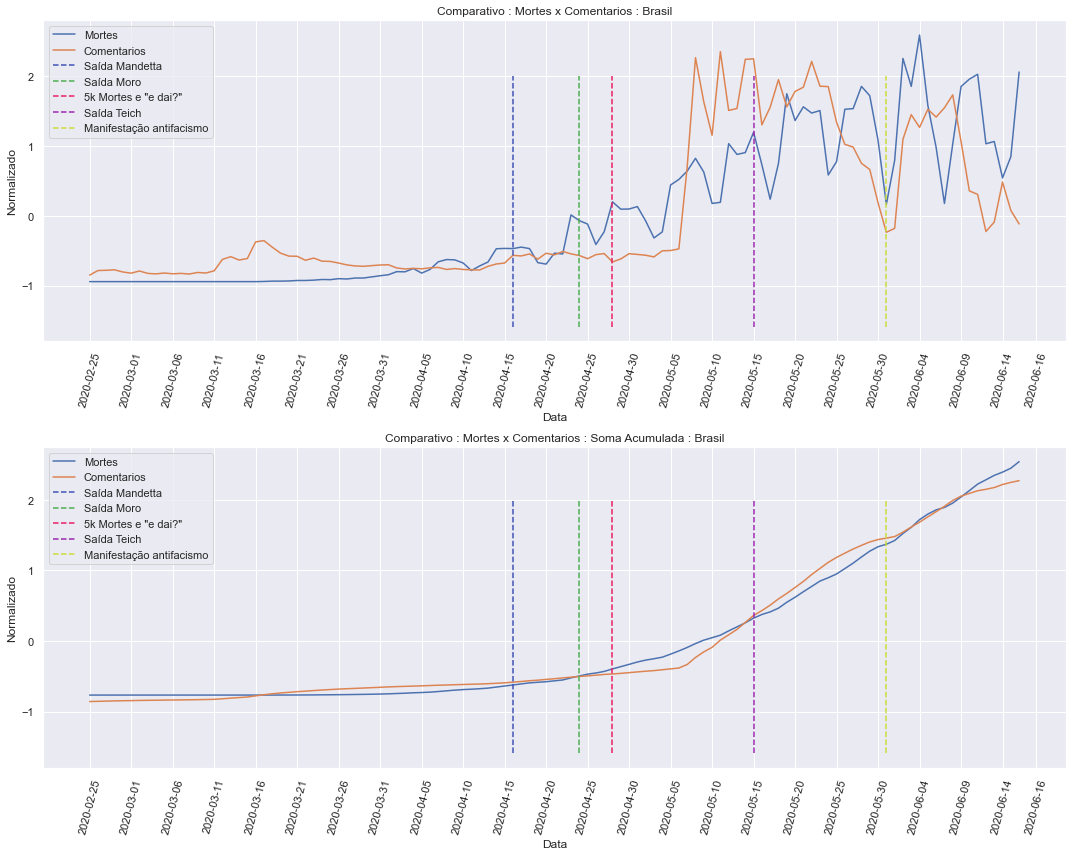

In [156]:
x1, x2 = gerar_graficos(df_merged["newDeaths"], df_merged["numComments"], datas, ["Mortes", "Comentarios"])

In [157]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.430894
p-value: 0.567379
Critical Values:
 - 1%: -3.497
 - 5%: -2.891
 - 10%: -2.582
Is the time series stationary? False

Mortes:
------------------------------
ADF Statistic: 0.451558
p-value: 0.983324
Critical Values:
 - 1%: -3.498
 - 5%: -2.891
 - 10%: -2.583
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -1.876285
p-value: 0.591985
Critical Values:
 - 1%: -3.997
 - 5%: -3.391
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


Da mesma maneira, ambas as séries são não estacionárias, portanto serão transformadas com o atraso de 1 dia.

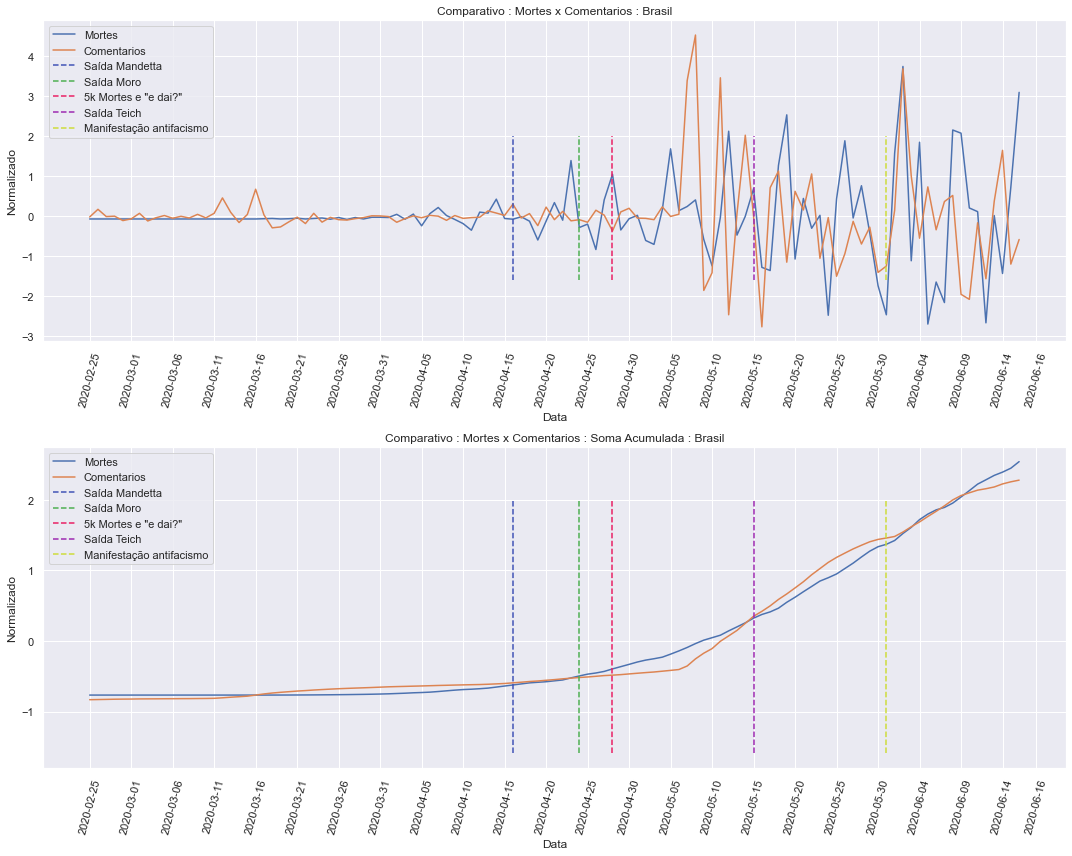

In [158]:
x1, x2 = gerar_graficos(df_merged["stationary_newDeaths"], df_merged["stationary_numComments"], datas, ["Mortes", "Comentarios"], stationary=True)

In [159]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -3.043767
p-value: 0.031004
Critical Values:
 - 1%: -3.496
 - 5%: -2.890
 - 10%: -2.582
Is the time series stationary? True

Mortes:
------------------------------
ADF Statistic: -1.869122
p-value: 0.346723
Critical Values:
 - 1%: -3.498
 - 5%: -2.891
 - 10%: -2.583
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -3.037122
p-value: 0.101643
Critical Values:
 - 1%: -3.997
 - 5%: -3.391
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


---

### Período Parcial

Conforme mencionado será analisado parte do período (a partir de 05/05).

#### Novos Casos x Comentários Positivos

In [160]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 5, 5)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

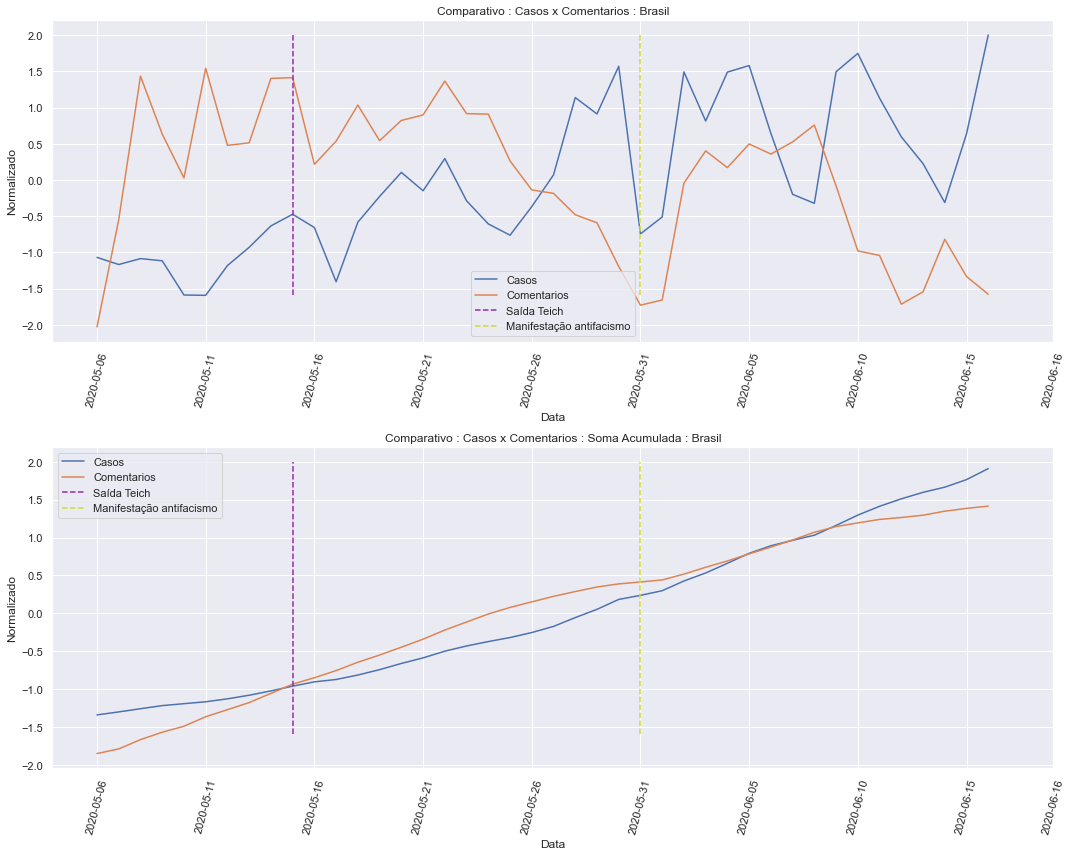

In [161]:
x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -2.681546
p-value: 0.077286
Critical Values:
 - 1%: -3.601
 - 5%: -2.935
 - 10%: -2.606
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: -1.695043
p-value: 0.433668
Critical Values:
 - 1%: -3.633
 - 5%: -2.949
 - 10%: -2.613
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -3.640100
p-value: 0.021837
Critical Values:
 - 1%: -4.184
 - 5%: -3.489
 - 10%: -3.15
Is time series cointegrate? True

Vector Error Correction Models (VECM):
------------------------------
Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
        0.4253          3.136   0.655 (2, 66)
---------------------------------------------



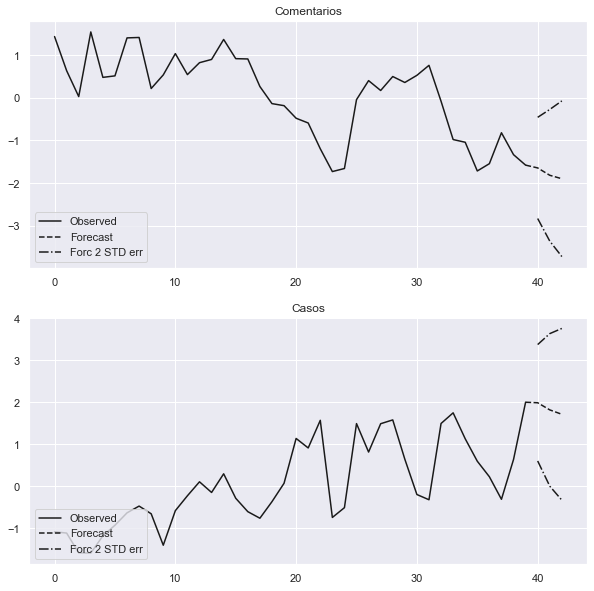

In [162]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

#### Mortes x Comentários Positivos

Dando sequência as validações, faz-se a verificação se os comentários no Twitter possuem uma relação causal na quantidade de mortes que ocorrem.

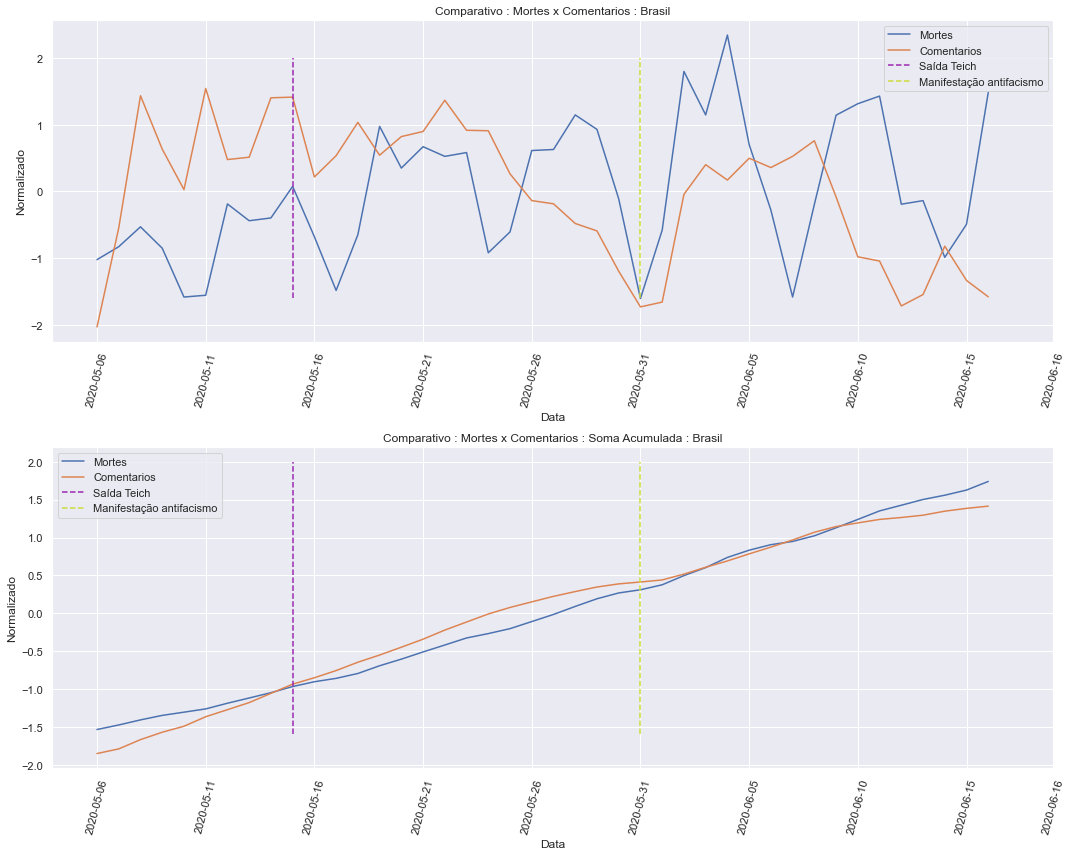

In [163]:
x1, x2 = gerar_graficos(df_merged["newDeaths"], df_merged["numComments"], datas, ["Mortes", "Comentarios"])

In [164]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -2.681546
p-value: 0.077286
Critical Values:
 - 1%: -3.601
 - 5%: -2.935
 - 10%: -2.606
Is the time series stationary? False

Mortes:
------------------------------
ADF Statistic: -2.439931
p-value: 0.130782
Critical Values:
 - 1%: -3.633
 - 5%: -2.949
 - 10%: -2.613
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -2.803613
p-value: 0.164538
Critical Values:
 - 1%: -4.184
 - 5%: -3.489
 - 10%: -3.15
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


---

### Período completo por estados

#### Novos Casos x Comentários Positivos (Sao Paulo)

In [203]:
covid_data_state = df_covid[["date", "state", "newCases", "newDeaths"]].copy()
covid_data_state["date"] = pd.to_datetime(covid_data_state["date"], format='%Y-%m-%d')
covid_data_state = covid_data_state[covid_data_state["state"] == "SP"]
covid_data_state = covid_data_state.groupby([covid_data_state["date"].dt.date]).sum().reset_index()

usr = users_[users_['state'] == 'SP'].copy()
df_dt = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data_state.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

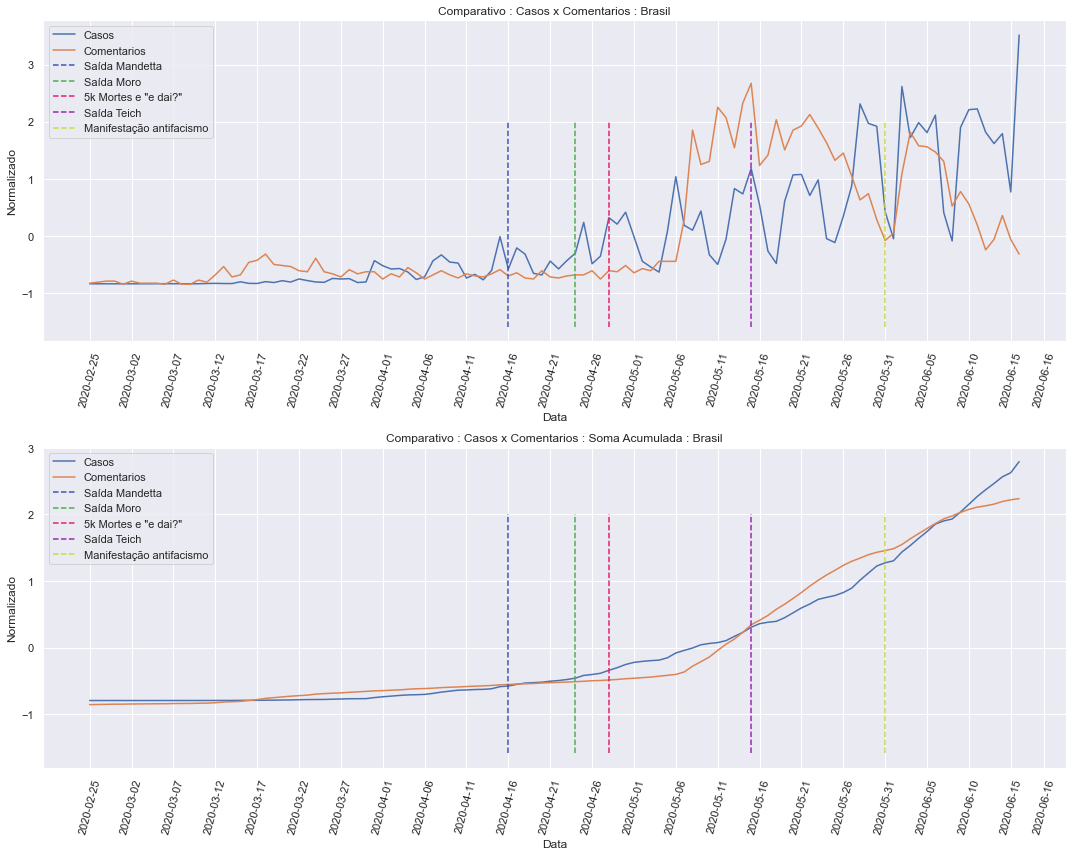

In [204]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [205]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.892616
p-value: 0.335543
Critical Values:
 - 1%: -3.498
 - 5%: -2.891
 - 10%: -2.583
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 3.792974
p-value: 1.000000
Critical Values:
 - 1%: -3.499
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -1.533570
p-value: 0.748096
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


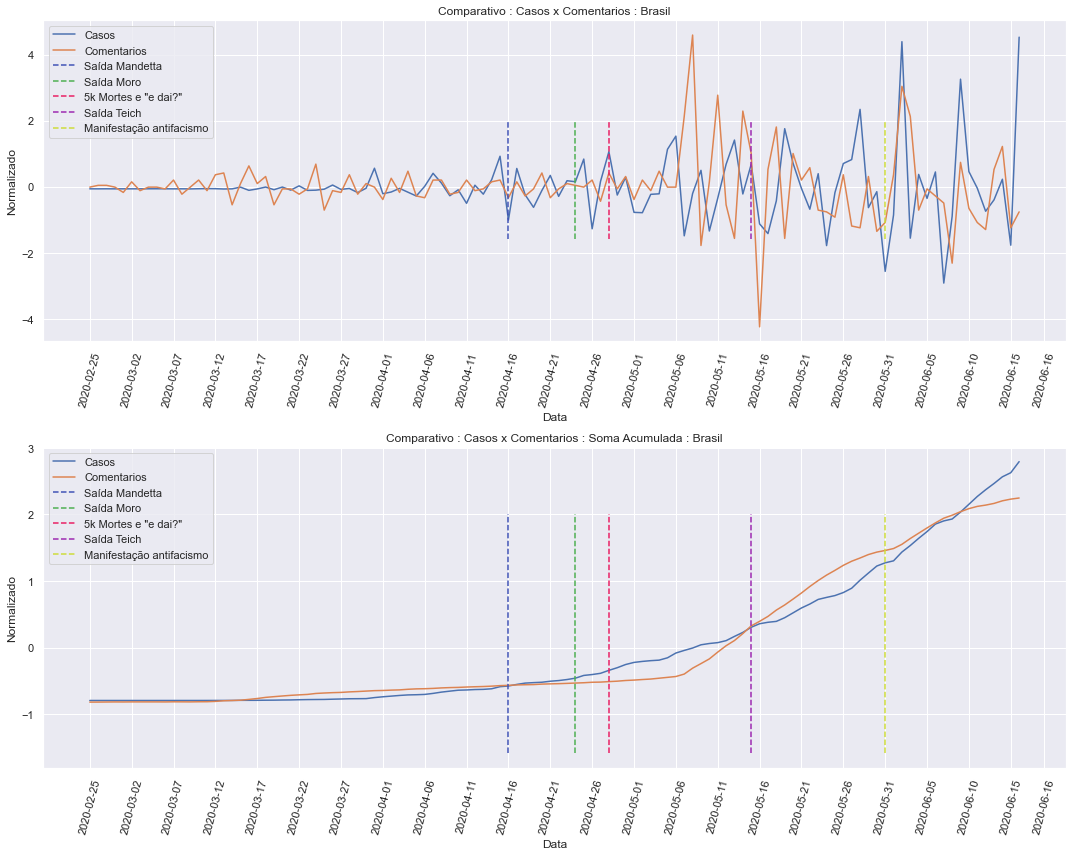

In [206]:
 x1, x2 = gerar_graficos(df_merged["stationary_newCases"], df_merged["stationary_numComments"], datas, ["Casos", "Comentarios"], stationary=True)

In [207]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.970795
p-value: 0.299524
Critical Values:
 - 1%: -3.498
 - 5%: -2.891
 - 10%: -2.582
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: -3.044906
p-value: 0.030908
Critical Values:
 - 1%: -3.499
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? True


Engle-Granger Test:
------------------------------

ADF Statistic: -1.875808
p-value: 0.592225
Critical Values:
 - 1%: -3.998
 - 5%: -3.392
 - 10%: -3.083
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


#### Novos Casos x Comentários Positivos (Rio de Janeiro)

In [208]:
covid_data_state = df_covid[["date", "state", "newCases", "newDeaths"]].copy()
covid_data_state["date"] = pd.to_datetime(covid_data_state["date"], format='%Y-%m-%d')
covid_data_state = covid_data_state[covid_data_state["state"] == "RJ"]
covid_data_state = covid_data_state.groupby([covid_data_state["date"].dt.date]).sum().reset_index()

usr = users_[users_['state'] == 'RJ'].copy()
df_dt = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data_state.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

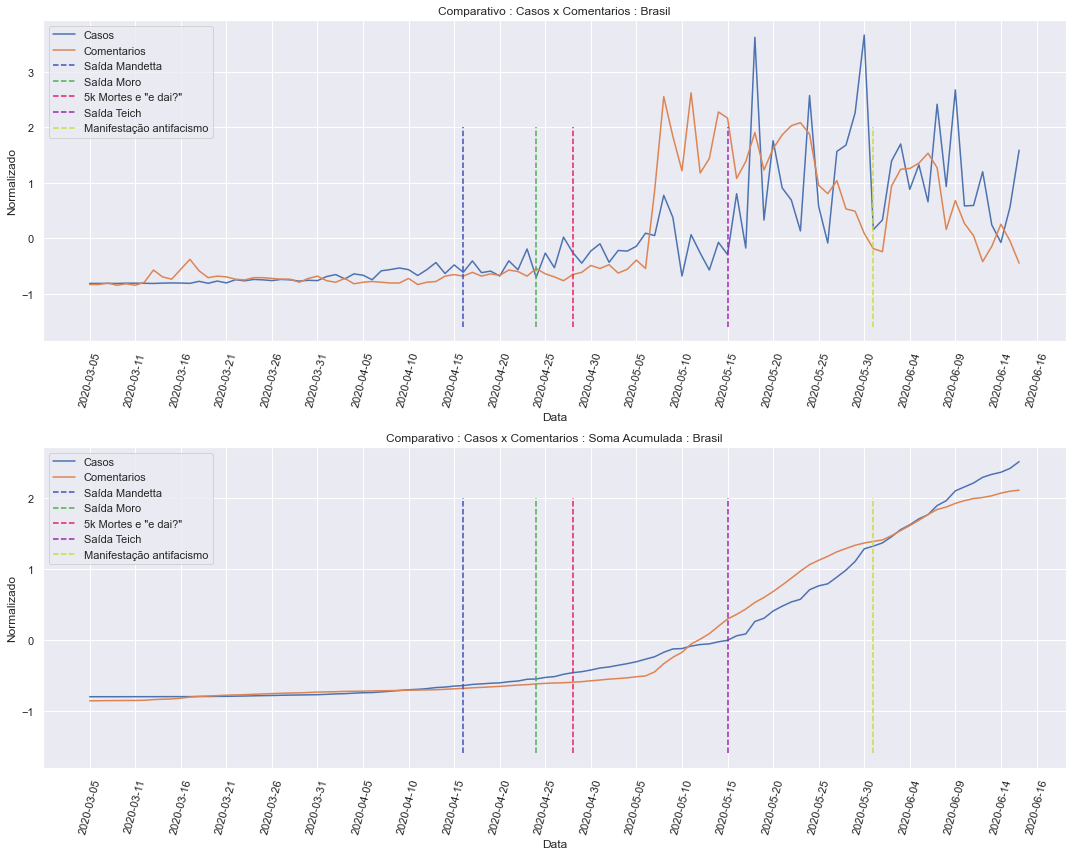

In [209]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [210]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.592265
p-value: 0.487478
Critical Values:
 - 1%: -3.500
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: -0.234108
p-value: 0.934332
Critical Values:
 - 1%: -3.503
 - 5%: -2.893
 - 10%: -2.584
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -1.777962
p-value: 0.640364
Critical Values:
 - 1%: -4.007
 - 5%: -3.397
 - 10%: -3.086
Is time series cointegrate? False

!!! Can find a model that could fit the series, please make the series stationary !!!


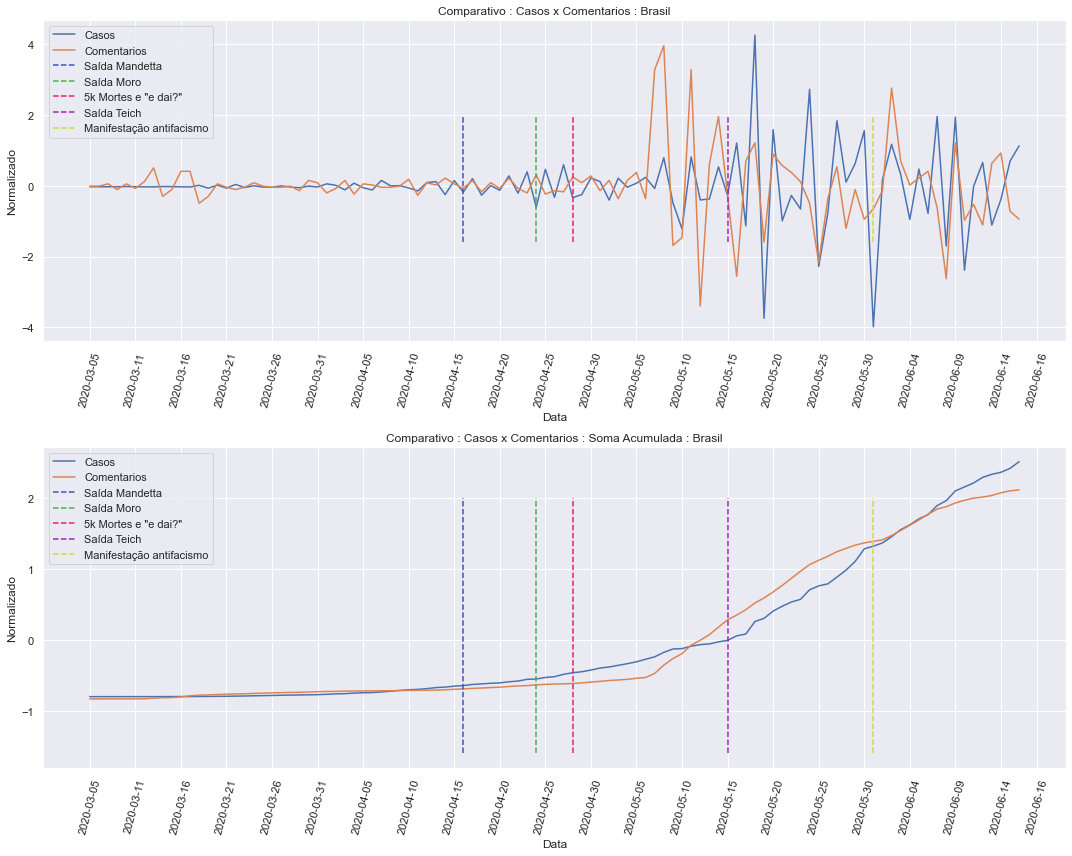

In [211]:
 x1, x2 = gerar_graficos(df_merged["stationary_newCases"], df_merged["stationary_numComments"], datas, ["Casos", "Comentarios"], stationary=True)

In [212]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -5.342789
p-value: 0.000004
Critical Values:
 - 1%: -3.499
 - 5%: -2.892
 - 10%: -2.583
Is the time series stationary? True

Casos:
------------------------------
ADF Statistic: -1.528960
p-value: 0.519140
Critical Values:
 - 1%: -3.506
 - 5%: -2.895
 - 10%: -2.584
Is the time series stationary? False


Engle-Granger Test:
------------------------------

ADF Statistic: -5.588451
p-value: 0.000012
Critical Values:
 - 1%: -4.007
 - 5%: -3.397
 - 10%: -3.086
Is time series cointegrate? True

!!! Can find a model that could fit the series, please make the series stationary !!!
